In [17]:
from pathlib import Path

from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
import cufflinks as cf
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


cf.go_offline()
DATA_DIR = Path('../data/processed')
MODEL_DIR = Path('../models')

SEED = 42

data = gpd.read_file(DATA_DIR / 'spatial_income_1880.gpkg')
data['is_old'] = data.is_old.astype(int)
data = data.drop(index=data[data.population < 5].index).dropna()
old_idx = data.index
data.reset_index(inplace=True)

In [18]:
N_COMPONENTS = 6
variables = [
    'lutheran',
    'orthodox',
    # 'is_old',
    'total_income_ln',
    'estate_income_ln',
    'salary_pension_income_ln',
    'business_income_ln',
    'orthodox_proportion',
]
X = StandardScaler().fit_transform(data.loc[:, variables])
pca = PCA(n_components=N_COMPONENTS, random_state=SEED).fit(X)
pca_components = pd.DataFrame(pca.components_.T, index=variables)
pca_transformed = gpd.GeoDataFrame(
    pca.fit_transform(X),
    index=old_idx,
    geometry=data.geometry,
    columns=list(range(1, N_COMPONENTS + 1)),
)
pca_transformed.to_csv(DATA_DIR / 'pca_transformed.csv')

factors = FactorAnalysis(rotation='varimax', n_components=N_COMPONENTS, random_state=SEED).fit(X)
factor_components = pd.DataFrame(factors.components_.T, index=variables)
factor_transformed = gpd.GeoDataFrame(
    factors.fit_transform(X),
    index=old_idx,
    geometry=data.geometry,
    columns=list(range(1, N_COMPONENTS + 1)),
)
factor_transformed.to_csv(DATA_DIR / 'factor_transformed.csv')

In [19]:
print(f"PCA\n"
      f"---\n"
      f"Explained variance: {pca.explained_variance_ratio_.round(2)} \n"
      f"Cumulative:         {pca.explained_variance_ratio_.cumsum().round(2)}")

PCA
---
Explained variance: [0.65 0.18 0.1  0.04 0.01 0.01] 
Cumulative:         [0.65 0.83 0.93 0.97 0.99 1.  ]


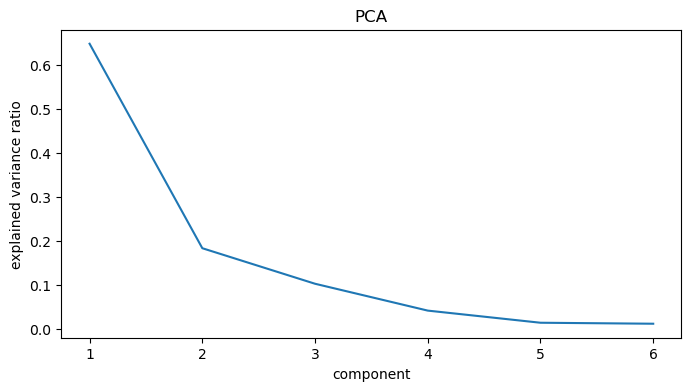

In [20]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 4)

ax.plot(list(range(1, N_COMPONENTS + 1)), pca.explained_variance_ratio_)
ax.set_title('PCA')
ax.set_ylabel('explained variance ratio')
ax.set_xlabel('component')
ax.set_xticks(list(range(1, N_COMPONENTS + 1)))

plt.show()

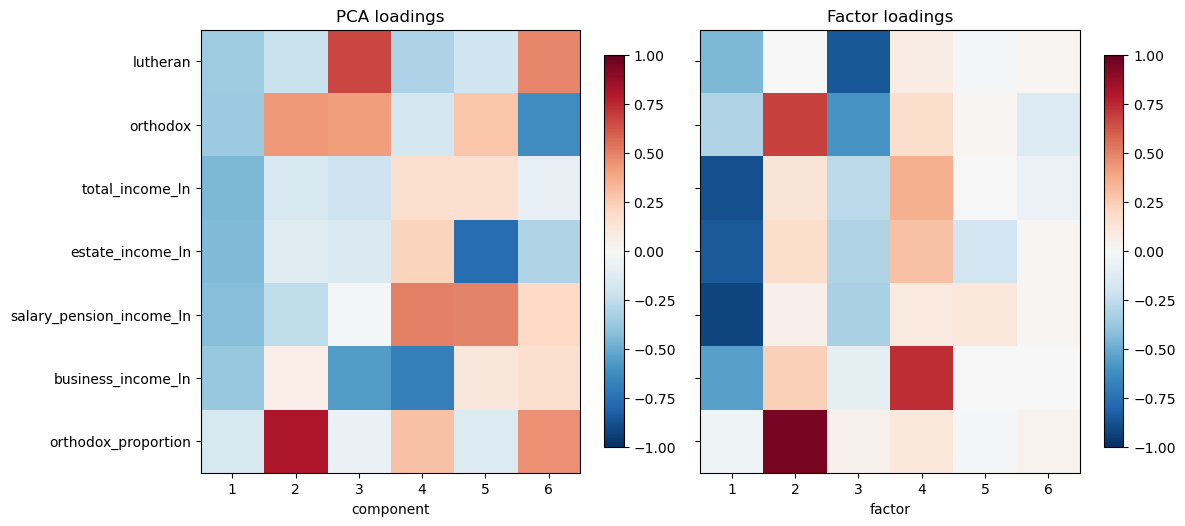

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

im_1 = ax1.imshow(pca_components, cmap='RdBu_r', vmin=-1, vmax=1)
ax1.set_title('PCA loadings')
ax1.set_xlabel('component')
ax1.set_yticks(list(range(len(variables))))
ax1.set_yticklabels(variables)
ax1.set_xticks(list(range(N_COMPONENTS)))
ax1.set_xticklabels(list(range(1, N_COMPONENTS + 1)))

im_2 = ax2.imshow(factor_components, cmap='RdBu_r', vmin=-1, vmax=1)
ax2.set_title('Factor loadings')
ax2.set_xlabel('factor')
ax2.set_yticks(list(range(len(variables))))
ax2.set_yticklabels(variables)
ax2.set_xticks(list(range(N_COMPONENTS)))
ax2.set_xticklabels(list(range(1, N_COMPONENTS + 1)))

fig.colorbar(im_1, ax=ax1, shrink=0.7)
fig.colorbar(im_2, ax=ax2, shrink=0.7)
fig.tight_layout()

plt.show()

array([[<AxesSubplot: xlabel='1', ylabel='1'>,
        <AxesSubplot: xlabel='2', ylabel='1'>,
        <AxesSubplot: xlabel='3', ylabel='1'>,
        <AxesSubplot: xlabel='4', ylabel='1'>],
       [<AxesSubplot: xlabel='1', ylabel='2'>,
        <AxesSubplot: xlabel='2', ylabel='2'>,
        <AxesSubplot: xlabel='3', ylabel='2'>,
        <AxesSubplot: xlabel='4', ylabel='2'>],
       [<AxesSubplot: xlabel='1', ylabel='3'>,
        <AxesSubplot: xlabel='2', ylabel='3'>,
        <AxesSubplot: xlabel='3', ylabel='3'>,
        <AxesSubplot: xlabel='4', ylabel='3'>],
       [<AxesSubplot: xlabel='1', ylabel='4'>,
        <AxesSubplot: xlabel='2', ylabel='4'>,
        <AxesSubplot: xlabel='3', ylabel='4'>,
        <AxesSubplot: xlabel='4', ylabel='4'>]], dtype=object)

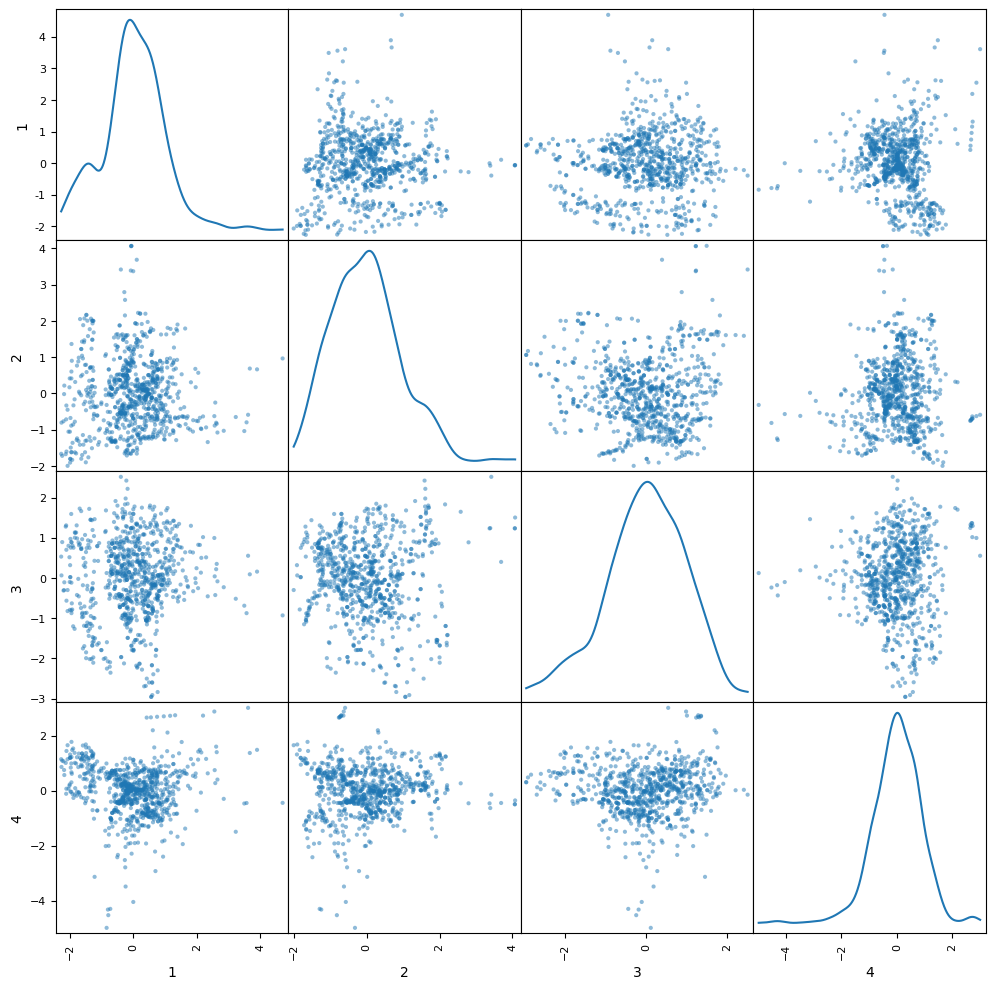

In [22]:
# scatter_matrix(pca_transformed.iloc[:, :4], figsize=(12, 12), diagonal='kde')
scatter_matrix(factor_transformed.iloc[:, :4], figsize=(12, 12), diagonal='kde')

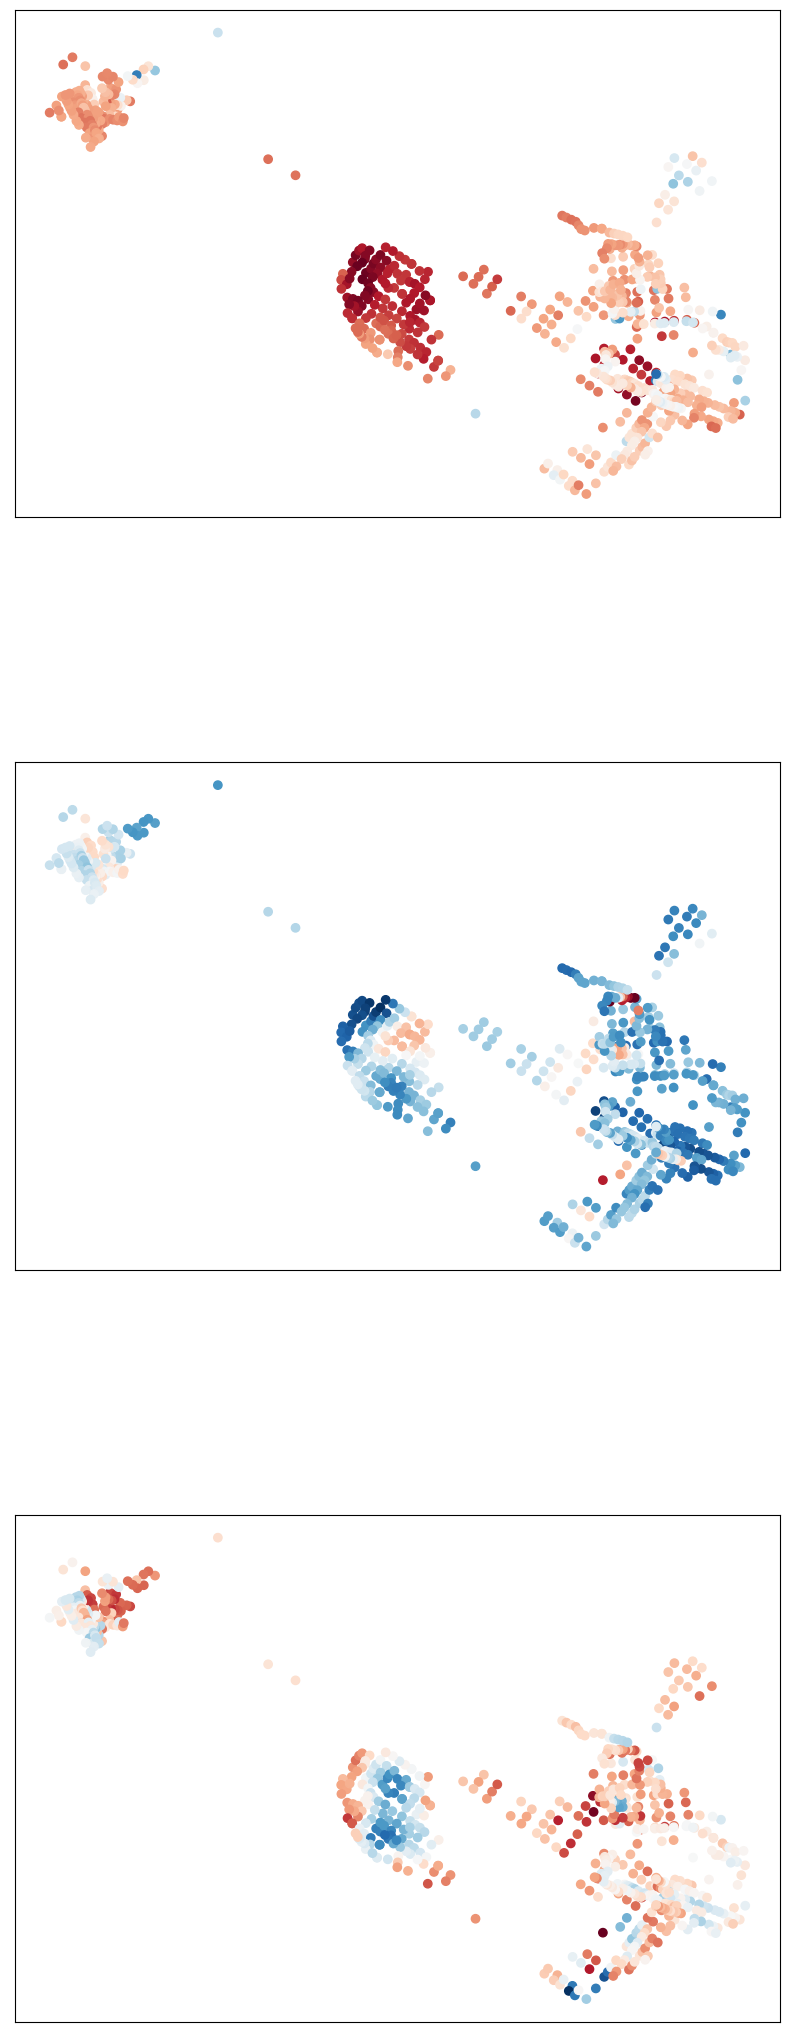

In [23]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(3, 1, figsize=(8, 24), subplot_kw={'xticks': [], 'yticks':[]})

factor_transformed.plot(
    column=1,
    cmap='RdBu',
    # legend=True,
    # vmin=-6,
    # vmax=6,
    ax=ax_1,
)
factor_transformed.plot(
    column=2,
    cmap='RdBu_r',
    # legend=True,
    # vmin=-6,
    # vmax=6,
    ax=ax_2,
)
factor_transformed.plot(
    column=3,
    cmap='RdBu_r',
    # legend=True,
    # vmin=-6,
    # vmax=6,
    ax=ax_3,
)
fig.tight_layout()
plt.show()